# Fashion MNIST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
fashion_mnist = fetch_openml(data_id=40996) 

In [3]:
type(fashion_mnist)

sklearn.utils.Bunch

In [4]:
labels_s = '0 T-shirt/top \n1 Trouser \n2 Pullover \n3 Dress \n4 Coat \n5 Sandal \n6 Shirt \n7 Sneaker \n8 Bag \n9 Ankle boot'

fashion_label_translation = {
    int(k): v for k, v in [
        item.split(maxsplit=1) for item in labels_s.split('\n')
    ]
}

def translate_label(y, translation=fashion_label_translation):
    return pd.Series(y).apply(lambda y: translation[int(y)]).values

In [5]:
def display_fashion(img, target, ax):
    
    if len(img.shape):
        w = int(np.sqrt(img.shape[0]))
        img = img.reshape((w, w))
    
    ax.imshow(img, cmap='Greys')
    ax.set_title(f'{target}')
    ax.grid(False)

In [6]:
from sklearn.model_selection import train_test_split

fashion_mnist_sample = {}

fashion_mnist_sample['data'], _, fashion_mnist_sample['target'], _ = train_test_split(
    fashion_mnist['data'],
    fashion_mnist['target'],
    train_size = 10_000,
    random_state= 121,
)

x, y = fashion_mnist_sample['data'], fashion_mnist_sample['target']
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    random_state=121,
)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler =MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
y_train_translated = translate_label(y_train)
y_test_translated = translate_label(y_test)

In [9]:
y_test_translated

['Ankle boot', 'Dress ', 'Sneaker ', 'Sandal ', 'Dress ', ..., 'Trouser ', 'Bag ', 'Coat ', 'Bag ', 'Pullover ']
Length: 2000
Categories (10, object): ['T-shirt/top ', 'Trouser ', 'Pullover ', 'Dress ', ..., 'Shirt ', 'Sneaker ',
                          'Bag ', 'Ankle boot']

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_translated)
y_test_encoded = encoder.transform(y_test_translated)

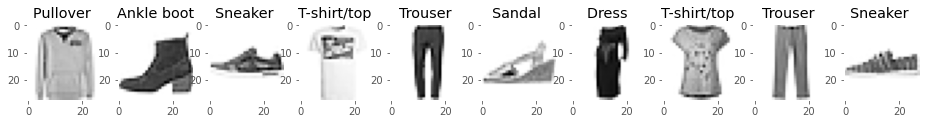

In [11]:
import random 

fig, axs = plt.subplots(1, 10, figsize=(16, 12))

for i in range(10):
    rand = random.choice(range(x_train.shape[0]))
    display_fashion(x_train[rand], y_train_translated[rand], axs[i])

fig.show()

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500)
clf.fit(x_train, y_train_encoded)
y_pred = clf.predict(x_test)

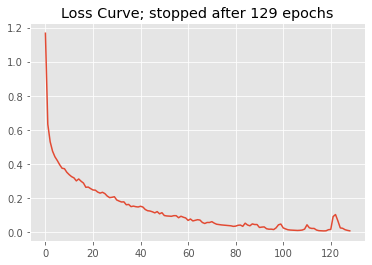

In [14]:
pd.Series(clf.loss_curve_).plot(
 title=f'Loss Curve; stopped after {clf.n_iter_} epochs'
)